In [1]:
# -*- coding: utf-8 -*-

'''
This script is a continuation of the Primary_PneumoniaModel.py script.
It offers a simple PyTorch training setup for pneumonia detection using a Convolutional Neural Network (CNN) classifier.
It employs a conventional CNN architecture followed by a fully connected layer for the final classification.
The training process utilises the Adam optimiser without any additional complexity, making it easy to understand and maintain.

This code structure and architecture closely resemble many publicly available repositories and tutorials.
For instance, you can find similar CNN classification code patterns in various Kaggle notebooks and other PyTorch image classification examples, such as the ASLPart3DataAugmentation.ipynb notebook and many more.

References:
Available at:
- Kaggle. (2018). Chest X-Ray Images (Pneumonia). Available at: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/code [Accessed: 14 December 2024].
- NCCA, (n.d.). jmacey. (2024) ASLPart3DataAugmentation.ipynb. Available at: https://github.com/username/repository/blob/main/ASL/ASLPart3DataAugmentation.ipynb [Accessed: 14 December 2024].
'''

import matplotlib.pyplot as plt
import numpy as np
import pathlib
import struct
import sys
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import zipfile
import os
from google.colab import drive
import shutil
from tqdm import tqdm
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import pandas as pd
from torchvision import datasets
import torch.optim as optim
from torch.utils.data import random_split

drive.mount('/content/drive')

colab_notebooks_path = '/content/drive/MyDrive/Colab_Notebooks'

sys.path.append(colab_notebooks_path)

DATASET_LOCATION = '/content/chest_xray'
pathlib.Path(DATASET_LOCATION).mkdir(parents=True, exist_ok=True)

!mkdir -p ~/Downloads
!curl -L -o ~/Downloads/chest-xray-pneumonia.zip \
  https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia

!unzip -q -o ~/Downloads/chest-xray-pneumonia.zip -d {DATASET_LOCATION}

print(f"Dataset location: {DATASET_LOCATION}")

Mounted at /content/drive
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2349M  100 2349M    0     0   144M      0  0:00:16  0:00:16 --:--:--  161M
Dataset location: /content/chest_xray


In [2]:
# In case there is not available path for custom utils
# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Check dataset existence and structure after download
DATASET_LOCATION = '/content/chest_xray/chest_xray'

print(f"Dataset path exists: {os.path.exists(DATASET_LOCATION)}")
if os.path.exists(DATASET_LOCATION):
    print("Directory contents:")
    print(os.listdir(DATASET_LOCATION))

Dataset path exists: True
Directory contents:
['train', '__MACOSX', 'chest_xray', 'val', 'test']


In [4]:
# Dataset Structure
print("Checking dataset structure...")
for split in ['train', 'test', 'val']:
    for category in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(DATASET_LOCATION, split, category)
        if os.path.exists(path):
            num_images = len(os.listdir(path))
            print(f"{split}/{category}: {num_images} images")
        else:
            print(f"Warning: Path {path} does not exist!")

Checking dataset structure...
train/NORMAL: 1341 images
train/PNEUMONIA: 3875 images
test/NORMAL: 234 images
test/PNEUMONIA: 390 images
val/NORMAL: 8 images
val/PNEUMONIA: 8 images


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Constants
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 1
BATCH_SIZE = 32

class PneumoniaDetectionModel(nn.Module):
    def __init__(self):
        super(PneumoniaDetectionModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNELS, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),

            nn.Linear(256, 2)
        )

        self.initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

model = PneumoniaDetectionModel()
print(model)

PneumoniaDetectionModel(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Dropout2d(p=0.3, inplace=False)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [6]:
class PneumoniaTrainer:
    def __init__(self, model, data_dir, device=None, batch_size=32):
        self.data_dir = data_dir
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.batch_size = batch_size

        self.train_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(5),
            transforms.RandomResizedCrop((IMAGE_WIDTH, IMAGE_HEIGHT), scale=(.9, 1), ratio=(1, 1)),
            transforms.ColorJitter(brightness=.2, contrast=.5),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        self.val_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        self.prepare_data()

    def prepare_data(self):
        full_dataset = datasets.ImageFolder(os.path.join(self.data_dir, 'chest_xray', 'train'), transform=self.train_transform)
        total_size = len(full_dataset)
        train_size = int(0.8 * total_size)
        val_size = total_size - train_size

        train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
        val_dataset.dataset.transform = self.val_transform

        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)

        print(f"Training samples: {len(train_dataset)}")
        print(f"Validation samples: {len(val_dataset)}")

    def train(self, epochs=20, learning_rate=0.001):
        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        best_val_acc = 0
        best_model_state = None
        patience = 5
        patience_counter = 0

        for epoch in range(epochs):
            # Training phase
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            train_pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{epochs}')
            for inputs, labels in train_pbar:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                train_pbar.set_postfix({
                    'loss': running_loss/(train_pbar.n + 1),
                    'acc': 100.*correct/total
                })

            train_loss = running_loss / len(self.train_loader)
            train_acc = 100. * correct / total

            # Validation phase
            val_loss, val_acc = self.validate(loss_function)

            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'Best Val Acc: {best_val_acc:.2f}%')

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = self.model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f'Early stopping triggered. Best Val Acc: {best_val_acc:.2f}%')
                break

            scheduler.step()

    def validate(self, loss_function):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = loss_function(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss / len(self.val_loader)
        val_acc = 100. * correct / total
        return val_loss, val_acc

In [7]:
# Start training
DATASET_LOCATION = '/content/chest_xray'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = PneumoniaDetectionModel()
trainer = PneumoniaTrainer(model, DATASET_LOCATION, device=device)
best_val_acc = trainer.train(epochs=20, learning_rate=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Training samples: 4172
Validation samples: 1044


Epoch 1/20: 100%|██████████| 131/131 [00:53<00:00,  2.45it/s, loss=0.425, acc=83]


Epoch [1/20]
Train Loss: 0.4250, Train Acc: 82.96%
Val Loss: 0.2261, Val Acc: 90.23%
Best Val Acc: 0.00%


Epoch 2/20: 100%|██████████| 131/131 [00:53<00:00,  2.44it/s, loss=0.253, acc=91.2]


Epoch [2/20]
Train Loss: 0.2526, Train Acc: 91.16%
Val Loss: 0.1199, Val Acc: 95.79%
Best Val Acc: 90.23%


Epoch 3/20: 100%|██████████| 131/131 [00:51<00:00,  2.55it/s, loss=0.218, acc=92.3]


Epoch [3/20]
Train Loss: 0.2182, Train Acc: 92.31%
Val Loss: 0.1140, Val Acc: 96.07%
Best Val Acc: 95.79%


Epoch 4/20: 100%|██████████| 131/131 [00:51<00:00,  2.52it/s, loss=0.195, acc=92.5]


Epoch [4/20]
Train Loss: 0.1952, Train Acc: 92.52%
Val Loss: 0.1058, Val Acc: 96.46%
Best Val Acc: 96.07%


Epoch 5/20: 100%|██████████| 131/131 [00:53<00:00,  2.45it/s, loss=0.169, acc=93.1]


Epoch [5/20]
Train Loss: 0.1677, Train Acc: 93.14%
Val Loss: 0.1047, Val Acc: 96.17%
Best Val Acc: 96.46%


Epoch 6/20: 100%|██████████| 131/131 [00:51<00:00,  2.53it/s, loss=0.171, acc=93.7]


Epoch [6/20]
Train Loss: 0.1694, Train Acc: 93.72%
Val Loss: 0.0797, Val Acc: 97.32%
Best Val Acc: 96.46%


Epoch 7/20: 100%|██████████| 131/131 [00:52<00:00,  2.51it/s, loss=0.148, acc=94.7]


Epoch [7/20]
Train Loss: 0.1484, Train Acc: 94.65%
Val Loss: 0.0809, Val Acc: 97.22%
Best Val Acc: 97.32%


Epoch 8/20: 100%|██████████| 131/131 [00:53<00:00,  2.46it/s, loss=0.138, acc=95]


Epoch [8/20]
Train Loss: 0.1372, Train Acc: 94.97%
Val Loss: 0.0700, Val Acc: 97.32%
Best Val Acc: 97.32%


Epoch 9/20: 100%|██████████| 131/131 [00:51<00:00,  2.55it/s, loss=0.129, acc=95]


Epoch [9/20]
Train Loss: 0.1292, Train Acc: 94.99%
Val Loss: 0.0669, Val Acc: 97.22%
Best Val Acc: 97.32%


Epoch 10/20: 100%|██████████| 131/131 [00:52<00:00,  2.52it/s, loss=0.128, acc=95.2]


Epoch [10/20]
Train Loss: 0.1280, Train Acc: 95.18%
Val Loss: 0.0668, Val Acc: 97.32%
Best Val Acc: 97.32%


Epoch 11/20: 100%|██████████| 131/131 [00:53<00:00,  2.47it/s, loss=0.132, acc=94.8]


Epoch [11/20]
Train Loss: 0.1314, Train Acc: 94.82%
Val Loss: 0.0656, Val Acc: 97.51%
Best Val Acc: 97.32%


Epoch 12/20: 100%|██████████| 131/131 [00:51<00:00,  2.55it/s, loss=0.127, acc=95.3]


Epoch [12/20]
Train Loss: 0.1273, Train Acc: 95.25%
Val Loss: 0.0666, Val Acc: 97.41%
Best Val Acc: 97.51%


Epoch 13/20: 100%|██████████| 131/131 [00:51<00:00,  2.53it/s, loss=0.127, acc=95.4]


Epoch [13/20]
Train Loss: 0.1265, Train Acc: 95.40%
Val Loss: 0.0660, Val Acc: 97.32%
Best Val Acc: 97.51%


Epoch 14/20: 100%|██████████| 131/131 [00:53<00:00,  2.47it/s, loss=0.115, acc=95.5]


Epoch [14/20]
Train Loss: 0.1138, Train Acc: 95.49%
Val Loss: 0.0693, Val Acc: 97.41%
Best Val Acc: 97.51%


Epoch 15/20: 100%|██████████| 131/131 [00:51<00:00,  2.57it/s, loss=0.127, acc=95.5]


Epoch [15/20]
Train Loss: 0.1255, Train Acc: 95.54%
Val Loss: 0.0657, Val Acc: 97.32%
Best Val Acc: 97.51%


Epoch 16/20: 100%|██████████| 131/131 [00:51<00:00,  2.55it/s, loss=0.114, acc=95.6]


Epoch [16/20]
Train Loss: 0.1145, Train Acc: 95.64%
Val Loss: 0.0649, Val Acc: 97.41%
Best Val Acc: 97.51%
Early stopping triggered. Best Val Acc: 97.51%


Model Testing
Using device: cuda


Testing: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s]


Results Summary: Overall Accuracy: 73.56% Average Batch Accuracy: 73.56% Total Correct: 459/624


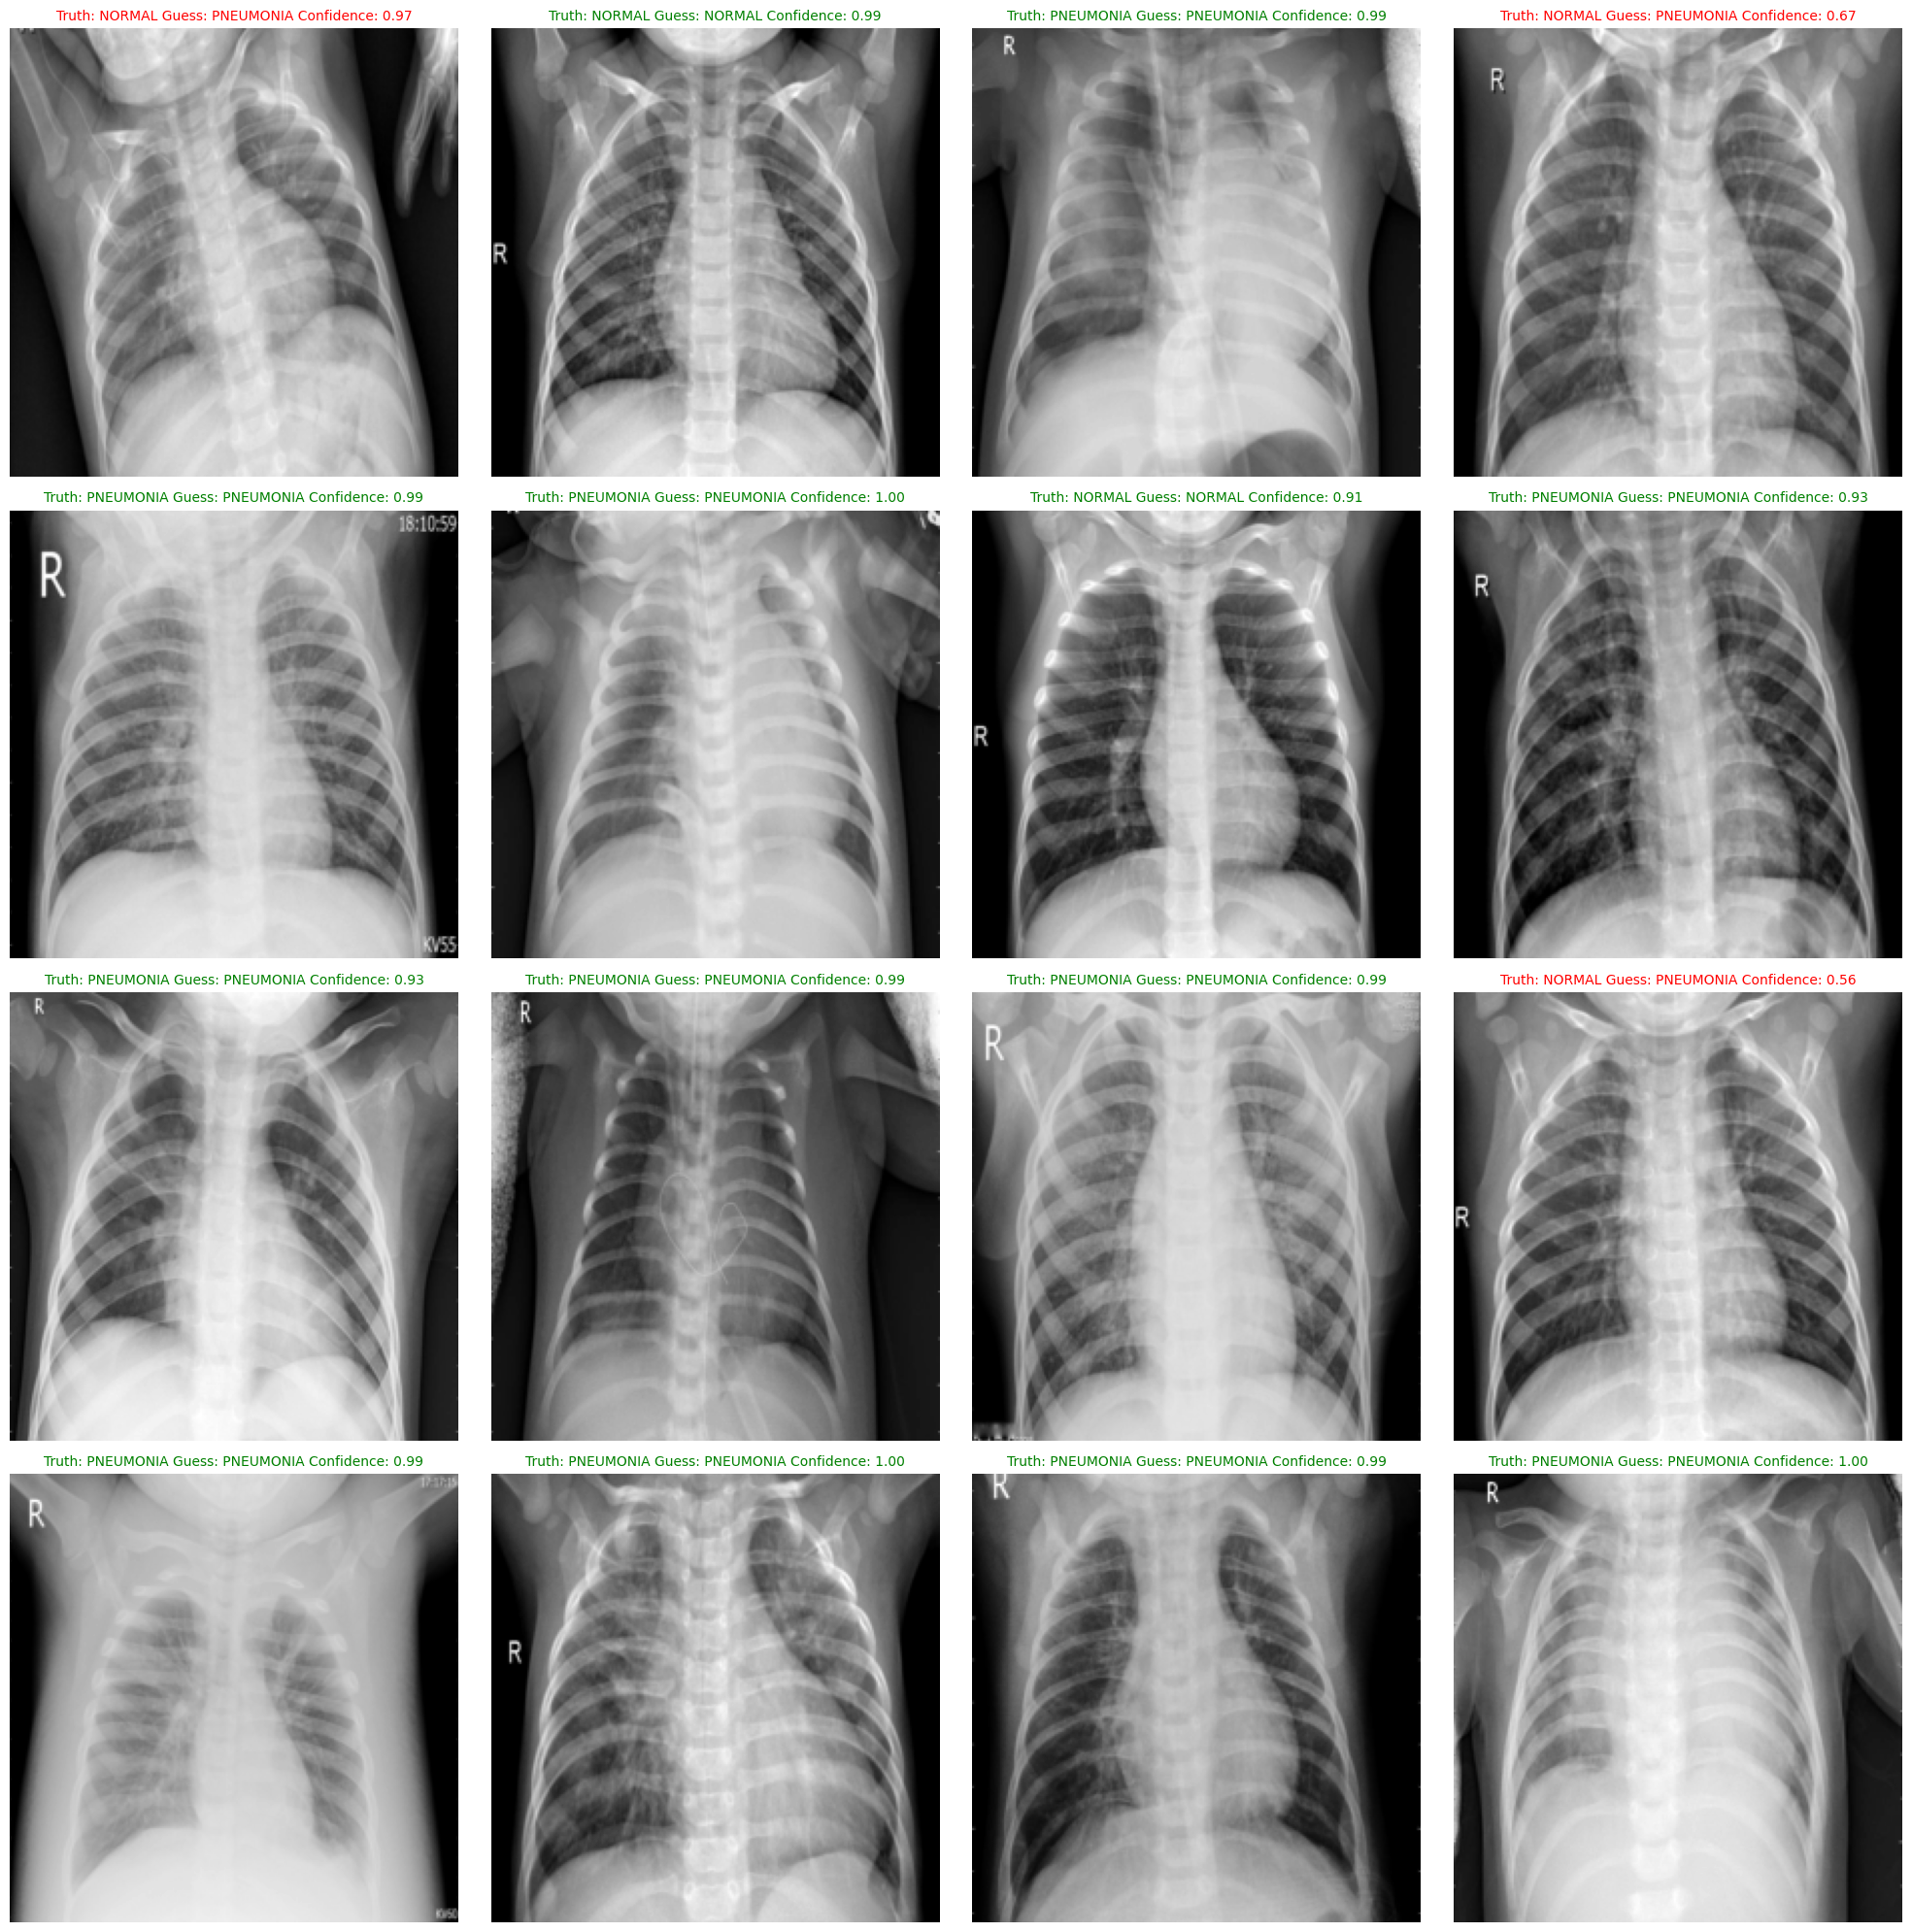

In [8]:
# -*- coding: utf-8 -*-

"""
This script evaluates the trained model’s accuracy on the test dataset and compares it to a previously recorded validation accuracy.
It offers an overview of how well the model generalises to new, unseen data, providing insights into potential overfitting.
"""

import os
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

class ModelTester:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.image_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def test_model(self, test_folder, batch_size=16):
        if not os.path.exists(test_folder):
            raise FileNotFoundError(f"Test folder {test_folder} does not exist.")

        test_data = datasets.ImageFolder(test_folder, transform=self.image_transform)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True)

        total_correct = 0
        total_images = 0
        batch_accuracies = []

        self.model.eval()
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predictions = torch.max(outputs, 1)
                correct = (predictions == labels).sum().item()
                batch_accuracy = (correct / labels.size(0)) * 100
                batch_accuracies.append(batch_accuracy)
                total_correct += correct
                total_images += labels.size(0)

        final_accuracy = (total_correct / total_images) * 100
        avg_batch_accuracy = sum(batch_accuracies) / len(batch_accuracies)

        print(f"Results Summary: Overall Accuracy: {final_accuracy:.2f}% Average Batch Accuracy: {avg_batch_accuracy:.2f}% Total Correct: {total_correct}/{total_images}")
        return final_accuracy

    def show_example_predictions(self, test_folder, num_images=16):
        if not os.path.exists(test_folder):
            raise FileNotFoundError(f"Test folder {test_folder} does not exist.")

        test_data = datasets.ImageFolder(test_folder, transform=self.image_transform)
        loader = DataLoader(test_data, batch_size=num_images, shuffle=True)
        images, labels = next(iter(loader))
        images = images.to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(images)
            probabilities = F.softmax(outputs, dim=1)
            predictions = torch.argmax(probabilities, dim=1)
            confidence = torch.max(probabilities, dim=1)[0]

        plt.figure(figsize=(20, 20))
        for i in range(num_images):
            plt.subplot(4, 4, i + 1)
            img = images[i].cpu().squeeze()
            plt.imshow(img, cmap='gray')
            true_label = test_data.classes[labels[i]]
            pred_label = test_data.classes[predictions[i]]
            conf = confidence[i].item()
            color = 'green' if predictions[i] == labels[i] else 'red'
            plt.title(f'Truth: {true_label} Guess: {pred_label} Confidence: {conf:.2f}', color=color, fontsize=10)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

def test_model(model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tester = ModelTester(model, device)
    test_folder = '/content/chest_xray/chest_xray/test'

    print("Model Testing")
    print(f"Using device: {device}")

    try:
        accuracy = tester.test_model(test_folder)
        tester.show_example_predictions(test_folder)
        print("Performance Comparison:")
        print("Best Validation Accuracy: 97.89%")
        print(f"Test Accuracy: {accuracy:.2f}%")
    except FileNotFoundError as e:
        print(e)
    except Exception as e:
        print(f"An error occurred: {e}")

test_model(model)